In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [10]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')

C:\Users\anike\AppData\Local\Temp\ipykernel_22940\2867026071.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [12]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468254,72.528574,71.223252,71.476592,135480400
2020-01-03,71.763741,72.523769,71.539352,71.696183,146322800
2020-01-06,72.335541,72.374146,70.634524,70.885457,118387200
2020-01-07,71.995369,72.600975,71.775804,72.345220,108872000
2020-01-08,73.153488,73.455087,71.698574,71.698574,132079200
...,...,...,...,...,...
2025-12-01,283.100006,283.420013,276.140015,278.010010,46587700
2025-12-02,286.190002,287.399994,282.630005,283.000000,53669500


<Axes: xlabel='Date'>

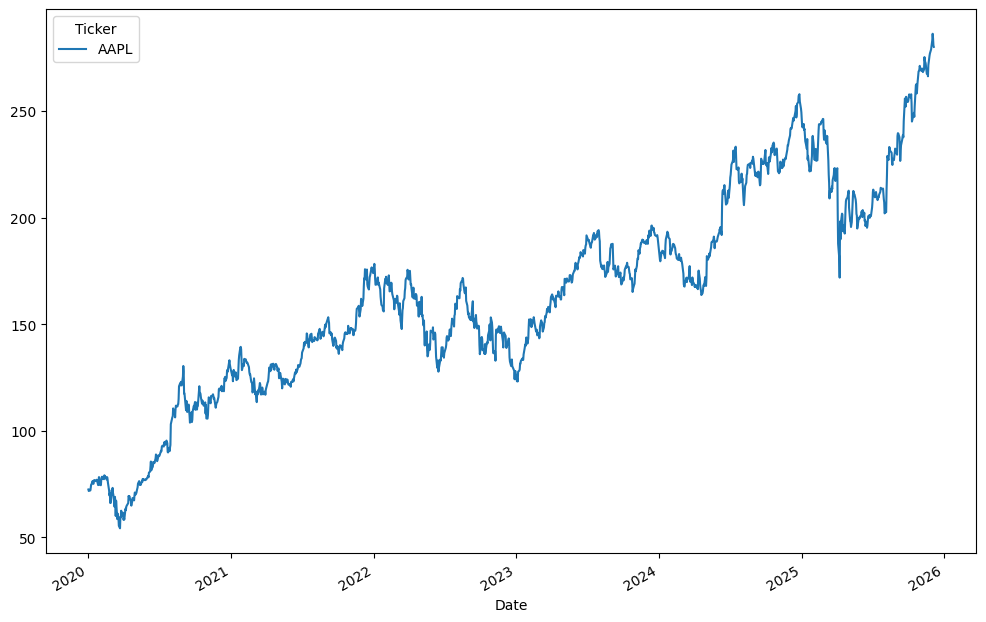

In [13]:
df.Close.plot(figsize=(12,8))

In [18]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close']) # mean=0 and sd=1

In [19]:
df['Close']

Ticker,AAPL
Date,
2020-01-02,-1.877736
2020-01-03,-1.892237
2020-01-06,-1.880468
2020-01-07,-1.887469
2020-01-08,-1.863631
...,...
2025-12-01,2.457792
2025-12-02,2.521394
2025-12-03,2.479404


In [21]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

In [23]:
train_size = (int(0.8 * len(data)))

X_train = torch.from_numpy(data[:train_size, :-1, :])
y_train = torch.from_numpy(data[:train_size, -1, :])
X_test = torch.from_numpy(data[train_size:, :-1, :])
y_test = torch.from_numpy(data[train_size:, -1, :])